Projeto 3 - Sistema de Recomendação de Receitas.

1 - Preparação do ambiente e das bases e visualizações.

In [ ]:
#Carregando as Livrarias essênciais.
import numpy
import pandas as pd
#Usaremos o pacote seaborn e matplotlib para gráficos.
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
#Usaremos a csr_matrix do pacote Scipy, esse metodo possibilitará criar uma matriz sparsa, agilizando o treinamento do modelo.
from scipy.sparse import csr_matrix
#Usaremos o algoritmo do KNN do Scikit Learn para o modelo.
from sklearn.neighbors import NearestNeighbors

#Carregando os dois datasets utilizados e criando uma copia adicional para referência futura.
recipes = pd.read_csv("https://media.githubusercontent.com/media/PedroCosDi/ProjetoAplicadoMack3/main/Dataset/RAW_recipes.csv")
interactions = pd.read_csv ("https://media.githubusercontent.com/media/PedroCosDi/ProjetoAplicadoMack3/main/Dataset/RAW_interactions.csv")
recipes_OG = recipes.copy(deep = True)

In [ ]:
#Escolhendo apenas as colunas 'id da receita', 'nome' do dataset com as receitas e renomeando-as
recipes = recipes[['id', 'name']]
recipes.rename(columns={'id' : 'ID_RECIPE', 'name': 'NAME_RECIPE'}, inplace= True)
recipes.head()

<ipython-input-2-d8b9a86ae845>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipes.rename(columns={'id' : 'ID_RECIPE', 'name': 'NAME_RECIPE'}, inplace= True)


,ID_RECIPE,NAME_RECIPE
0,137739,arriba baked winter squash mexican style
1,31490,a bit different breakfast pizza
2,112140,all in the kitchen chili
3,59389,alouette potatoes
4,44061,amish tomato ketchup for canning


In [ ]:
#Escolhendo apenas as colunas 'id de usuário', 'id da receita' e 'avaliação' do dataset com as avaliações e renomeando-as.
interactions = interactions[['user_id', 'recipe_id', 'rating']]
interactions.rename(columns={'user_id' : 'ID_USER', 'recipe_id': 'ID_RECIPE', 'rating' : 'RATING'}, inplace= True)
interactions.head()

,ID_USER,ID_RECIPE,RATING
0,38094,40893,4
1,1293707,40893,5
2,8937,44394,4
3,126440,85009,5
4,57222,85009,5


In [ ]:
#Exibimos informações dos datasets
print(interactions.info())
print(recipes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   ID_USER    1132367 non-null  int64
 1   ID_RECIPE  1132367 non-null  int64
 2   RATING     1132367 non-null  int64
dtypes: int64(3)
memory usage: 25.9 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID_RECIPE    231637 non-null  int64 
 1   NAME_RECIPE  231636 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.5+ MB
None


In [ ]:
#Verificamos que há 1 valor nulo.
recipes.isna().sum()

ID_RECIPE      0
NAME_RECIPE    1
dtype: int64

In [ ]:
#Dropamos a linha de valor nulo
recipes.dropna(inplace = True)

In [ ]:
#Verificamos novamente.
recipes.isna().sum()

ID_RECIPE      0
NAME_RECIPE    0
dtype: int64

In [ ]:
#Verificamos que não há valores nulos em interacoes.
interactions.isna().sum()

ID_USER      0
ID_RECIPE    0
RATING       0
dtype: int64

In [ ]:
#Verificamos quantidade de avaliações das receitas
interactions['ID_USER'].value_counts()

424680        7671
37449         5603
383346        4628
169430        4076
128473        3917
              ... 
244983           1
139446           1
495446           1
113469           1
2001868099       1
Name: ID_USER, Length: 226570, dtype: int64

In [ ]:
#Nos preparamos para descartar os usuários com menos de 100 reviews, observamos que temos 1382 usuários
qt_ratings = interactions['ID_USER'].value_counts() > 99
rel_id = qt_ratings[qt_ratings].index
rel_id.shape

(1382,)

In [ ]:
#Descartamos todas as reviews que foram feitas por usuários que não tiveram pelo menos 100 reviews.
interactions = interactions[interactions['ID_USER'].isin(rel_id)]

In [ ]:
#Unimos os dois datasets (511886 linhas).
recipe_interact = interactions.merge(recipes, on = 'ID_RECIPE')
recipe_interact

,ID_USER,ID_RECIPE,RATING,NAME_RECIPE
0,126440,85009,5,baked potato toppings
1,57222,85009,5,baked potato toppings
2,52282,120345,4,sugared raspberries
3,124416,120345,0,sugared raspberries
4,76535,134728,4,kfc honey bbq strips
...,...,...,...,...
511881,39835,249924,5,rocky mount nc bbq chicken sandwiches
511882,496803,249924,5,rocky mount nc bbq chicken sandwiches
511883,169430,470995,5,perfectly fried shrimps with garlic
511884,1269180,257796,4,slow cooker garlic chicken with rosemary


In [ ]:
#Verificando a estatistica sumarizada do dataset unido.
recipe_interact.describe()

,ID_USER,ID_RECIPE,RATING
count,5.118860e+05,511886.000000,511886.000000
mean,6.654330e+06,184916.003735,4.628353
std,1.102860e+08,134016.623932,0.844466
min,1.533000e+03,38.000000,0.000000
25%,8.723600e+04,70951.750000,5.000000
50%,1.970230e+05,153891.000000,5.000000
75%,3.952520e+05,282394.000000,5.000000
max,2.001103e+09,537459.000000,5.000000


In [ ]:
#Removemos o ID_Receita, pois já estamos utilizando o nome da receita.
del recipe_interact['ID_RECIPE']

In [ ]:
recipe_interact

,ID_USER,RATING,NAME_RECIPE
0,126440,5,baked potato toppings
1,57222,5,baked potato toppings
2,52282,4,sugared raspberries
3,124416,0,sugared raspberries
4,76535,4,kfc honey bbq strips
...,...,...,...
511881,39835,5,rocky mount nc bbq chicken sandwiches
511882,496803,5,rocky mount nc bbq chicken sandwiches
511883,169430,5,perfectly fried shrimps with garlic
511884,1269180,4,slow cooker garlic chicken with rosemary


In [ ]:
#Verificando a frequencia das receitas mais solicitadas(nome da receita e quantidade de avaliaçoes).
freq_itens = pd.value_counts(recipe_interact['NAME_RECIPE'])
freq_itens

to die for crock pot roast                           274
crock pot chicken with black beans   cream cheese    213
japanese mum s chicken                               212
jo mama s world famous spaghetti                     209
kittencal s 5 minute cinnamon flop brunch cake       204
                                                    ... 
baked potato onion wrap ups                            1
crunchy cabbage salad                                  1
caldeirada  portuguese fish stew                       1
heart healthy carrot cake                              1
nee nee s old timey tea cakes                          1
Name: NAME_RECIPE, Length: 173618, dtype: int64

Text(0, 0.5, 'Frequencia')

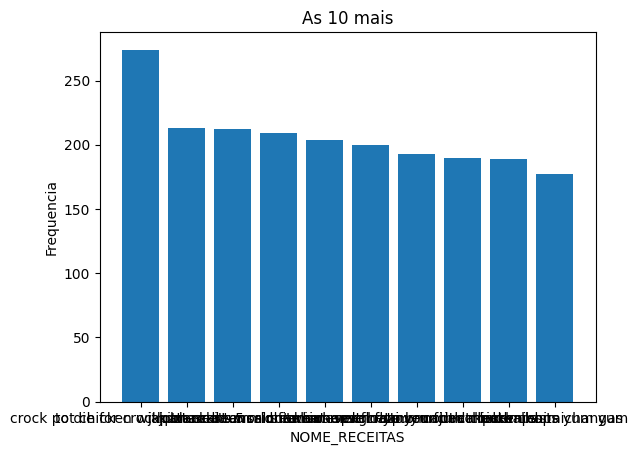

In [ ]:
#Plotamos gráfico das receitas mais solicitadas.
plt.bar(freq_itens.index[:10], freq_itens.values[:10])
plt.title("As 10 mais")
plt.xlabel("NOME_RECEITAS")
plt.ylabel("Frequencia")

In [ ]:
#Verificamos a frequencia das avaliaçoes das receitas (id da receita).
freq_itens = pd.value_counts(recipe_interact['RATING'])
freq_itens

5    384212
4     97377
3     17018
0      8921
2      3209
1      1149
Name: RATING, dtype: int64

Text(0, 0.5, 'NUM RECEITAS')

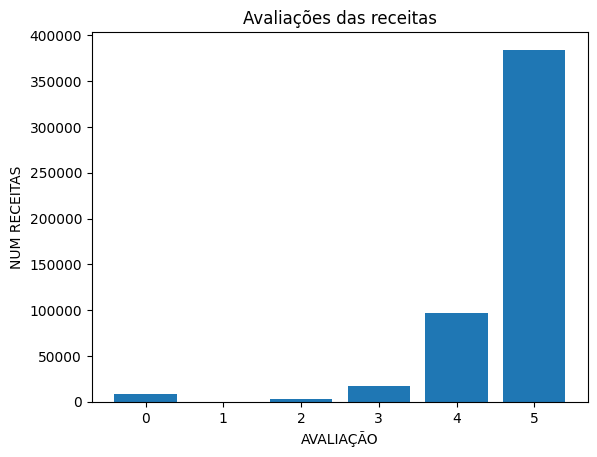

In [ ]:
#Plotamos o gráfico da análise acima.
plt.bar(freq_itens.index[:5], freq_itens.values[:5])
plt.title("Avaliações das receitas")
plt.xlabel("AVALIAÇÃO")
plt.ylabel("NUM RECEITAS")

In [ ]:
#Fazemos um pivot para que queremos que cada ID_USUARIO seja uma variavel, criando um dataset com as receitas como linhas e os usuários como colunas.
recipe_eval_pivot = recipe_interact.pivot_table(columns = 'ID_USER', index = 'NAME_RECIPE', values = 'RATING')
recipe_eval_pivot = recipe_eval_pivot.fillna(0)
recipe_eval_pivot

ID_USER,1533,1535,2310,2312,3288,4291,4439,4470,4740,5060,...,2206637,2324285,2399085,2549237,2597942,1800054678,1802849661,2000431901,2000498330,2001102678
NAME_RECIPE,,,,,,,,,,,,,,,,,,,,,
0 fat chunky watermelon salsa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 point soup ww,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0 point soup crock pot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
007 martini,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
007 cocktail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zydeco sauce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zydeco shrimp wrap,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zydeco soup,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Transformamos nosso dataset em uma matriz sparsa.
recipe_eval_pivot_sparse = csr_matrix(recipe_eval_pivot)

In [ ]:
#Exibimos o tipo e objeto, para verificação.
type(recipe_eval_pivot_sparse)

scipy.sparse._csr.csr_matrix

2 - Prova de Conceito: Modelo Inicial e visualizções.

In [ ]:
#Criamos e treinando o modelo preditivo.

modelo = NearestNeighbors(algorithm = 'brute')
modelo.fit(recipe_eval_pivot_sparse)

NearestNeighbors(algorithm='brute')

In [ ]:
#Começamos com uma prova de conceito básica, realizando testes e previsoes de sugestoes de receitas.
#Previsão de receitas: lemonade made with stevia

distances, sugestions = modelo.kneighbors(recipe_eval_pivot.filter(items= ['lemonade made with stevia'], axis = 0).values.reshape(1, -1))

for i in range(len(sugestions)):
  print(recipe_eval_pivot.index[sugestions[i]])
  print(distances)

Index(['lemonade made with stevia', 'cheese enchiladas with green sauce',
       'cottage cheese', 'muffuletta bread', 'muffuletta sandwiches'],
      dtype='object', name='NAME_RECIPE')
[[ 0.         10.44030651 11.18033989 11.18033989 11.18033989]]


In [ ]:
#Previsão de receitas: almond cupcakes

distances, sugestions = modelo.kneighbors(recipe_eval_pivot.filter(items= ['almond cupcakes'], axis = 0).values.reshape(1, -1))

for i in range(len(sugestions)):
  print(recipe_eval_pivot.index[sugestions[i]])

Index(['almond cupcakes', 'gingerbread breakfast loaf', 'tater tots hotdish',
       'easy  delicious   low carb taco soup',
       'zone style flourless pancakes'],
      dtype='object', name='NAME_RECIPE')


In [ ]:
# #Exibimos também um mapa de calor das avaliaçoes feitas pelos usuarios das receitas.
# recipe_eval_pivot = numpy.asarray(recipe_interact.RATING).reshape(511886,1)
# sns.heatmap(recipe_eval_pivot,cmap=ListedColormap(['green', 'yellow', 'red']))
# plt.show()

# Comentado para evitar conflito do numpy com o programa.

3 - Métricas de Avaliação e seu ambiente.

In [ ]:
#Vamos instalar o pacote surprise e importar seus pacotes, utilizando-os à seguir.
!pip install surprise

from surprise import Reader, Dataset
from surprise.prediction_algorithms.knns import KNNBaseline
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.slope_one import SlopeOne
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise import accuracy
from surprise import SVD
from surprise.model_selection import cross_validate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163347 sha256=ffff815260ed288a3f26d88487b0af7243079acc8bfad24a5f4c34b41c54b22b
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
#Avaliamos numeros da base de dados.
print('Quantidade de receitas avaliadas:', recipe_interact['NAME_RECIPE'].value_counts().shape[0])
print('Quantidade de usuários avaliando:', recipe_interact['ID_USER'].value_counts().shape[0])
print('Quantidade de avaliações:', recipe_interact['RATING'].shape[0])

Quantidade de receitas avaliadas: 173618
Quantidade de usuários avaliando: 1382
Quantidade de avaliações: 511886


In [ ]:
#Exibimos as top5 receitas com avaliaçoes.
recipe_interact['NAME_RECIPE'].value_counts().head()

to die for crock pot roast                           274
crock pot chicken with black beans   cream cheese    213
japanese mum s chicken                               212
jo mama s world famous spaghetti                     209
kittencal s 5 minute cinnamon flop brunch cake       204
Name: NAME_RECIPE, dtype: int64

In [ ]:
#Verificamos quais sao as receitas avaliadas por um determinado usuario.
recipe_interact.query('ID_USER== 126440').head()

,ID_USER,RATING,NAME_RECIPE
0,126440,5,baked potato toppings
680,126440,5,world s best tabbouli tabouli tabbouleh ...
1018,126440,5,down home breakfast special
1758,126440,5,vanilla walnuts
2072,126440,5,fruit salsa and cinnamon chips


In [ ]:
#Configuramos o ambiente para o treinamento do surprise. e selecionamos as variáveis para o modelo.
reader = Reader(rating_scale=(0,5))
recipe_interact_surprise = Dataset.load_from_df(recipe_interact[['ID_USER','NAME_RECIPE','RATING']], reader)
recipe_interact_surprise
#Dividimos os dados de treino e teste.
trainset, testset = train_test_split(recipe_interact_surprise, test_size=0.30, random_state=42)
# Configuramos as medidas de similaridade baseadas nos usuarios
sim_options = { 'name': 'pearson_baseline', 'user_based': True }

In [ ]:
#Criamos o modelo knn.
knn = KNNBaseline(k=33, sim_options=sim_options);
#Treinamos o modelo
knn.fit(trainset);

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
# #Criamos o modelo slope.
# slo = SlopeOne();
# #Treinamos o modelo
# slo.fit(trainset);



In [ ]:
#Criamos o modelo CoClustering.
co = CoClustering(n_epochs=10, verbose=True, random_state=42);
#Treinamos o modelo
co.fit(trainset);

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [ ]:
#Por fim, avaliamos os modelos - metrica escolhida é a Raiz do Erro Quadratico Medio (RMSE) das previsoes.
# RMSE para o KNN Baseline
predictions_knn = knn.test(testset)
accuracy.rmse(predictions_knn)

RMSE: 0.8672


0.8672153538470811

In [ ]:
# #RMSE para o SlopeOne
# predictions_slo = slo.test(testset)
# accuracy.rmse(predictions_slo)

# #AVISO: O modelo SlopeOne está estourando a memória, será alterado numa etapa futura.

In [ ]:
#RMSE para o modelo CoClustering
predictions_co = co.test(testset)
accuracy.rmse(predictions_co)

RMSE: 0.8954


0.8953858318665203

In [ ]:
#Também fazemos o cross-validate usano o método SVD através do pacote surprise.
cross_validate(SVD(), recipe_interact_surprise, measures =['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8025  0.7948  0.8085  0.8051  0.8024  0.8027  0.0045  
MAE (testset)     0.4734  0.4707  0.4760  0.4747  0.4752  0.4740  0.0019  
Fit time          16.26   14.08   14.05   14.27   14.08   14.55   0.86    
Test time         2.15    1.94    1.43    0.83    0.83    1.44    0.55    


{'test_rmse': array([0.80246862, 0.79479563, 0.80850955, 0.80506858, 0.80242248]),
 'test_mae': array([0.47340195, 0.47070176, 0.47601706, 0.47465099, 0.47520631]),
 'fit_time': (16.264512062072754,
  14.079007863998413,
  14.053418397903442,
  14.274909496307373,
  14.077628135681152),
 'test_time': (2.1490023136138916,
  1.9384686946868896,
  1.433701992034912,
  0.8311920166015625,
  0.8325395584106445)}

4 - Programa de Recomendação.

In [ ]:
#Definimos o Programa de Recomendação, baseando-se na prova de conceito anterior que usou o knn.
def rec_recipe(name, num):
  distances, sugestions = modelo.kneighbors(recipe_eval_pivot.filter(items= [name], axis = 0).values.reshape(1, -1))

  if (num > 0) & (num < 6):
    print(f'Loading results for: {name}')
    for i in range(0, num):
      rec_name = recipe_eval_pivot.index[sugestions[0][i]]
      temp = recipes_OG[(recipes_OG["name"] == rec_name)]
      print('-----')
      print(f'Closest recipe {i+1}: {rec_name}')
      print(f'Minutes: {temp["minutes"].values[0]}')
      print(f'Number of steps: {temp["n_steps"].values[0]}')
      print(f'Description: {temp["description"].values[0]}')
      print(f'Ingredients: {temp["ingredients"].values[0]}')
      print(f'Tags: {temp["tags"].values[0]}')
      print('How to prepare:')
      print(temp["steps"].values[0])
  else:
    print('Please, specify a number from 1 to 5')
  print('-----')
  print('End of recomendations')

In [ ]:
#Programa de recomendação, necessita da entrada do nome da receita específica da base de dados e uma entrada numérica de 1 à 5.
rec_recipe('lamb and feta rissoles', 2)

Loading results for: lamb and feta rissoles
-----
Closest recipe 1: corn muffins with cheese and nuts
Minutes: 20
Number of steps: 12
Description: these are very easy to make and great when eaten warm with melting butter.
Ingredients: ['yellow cornmeal', 'flour', 'sugar', 'salt', 'baking powder', 'white pepper', 'cheddar cheese', 'pecans', 'eggs', 'milk', 'butter']
Tags: ['30-minutes-or-less', 'time-to-make', 'course', 'preparation', 'breads', 'lunch', 'easy', 'kosher', 'muffins', 'dietary', 'high-calcium', 'quick-breads', 'high-in-something']
How to prepare:
['preheat oven to 425f', 'grease the muffin tins', 'mix , in a medium bowl , cornmeal , flour , sugar , salt , baking powder , and white pepper', 'add cheese and nuts', 'in another bowl , whisk the eggs', 'add milk and melted butter', 'mix the dry ingredients into the liquid mixture', 'stir until just combined', 'spoon the batter into prepared muffin tins', 'bake for ten minutes', 'let the muffins sit in the tins for a few minutes